# Processing Satellite Imagery

In this section we turn to **raster** data, specifically, to satellite imagery.  To get started, we must select an "area of interest" where we want to study -- in our case, the **bounding box** around the redlining polygons of whichever city we have chosen.  Given a `geopandas` data frame of our city, we can extract the bounding box in using the `.total_bounds()` method[^1]

[^1]: Actually for the stac catalog search, we will need to know the bounding box in the longitude-latitude coordinate reference system, known by code name EPSG:4326.  Fortunately our data is already in this projection.

In [1]:
import ibis
from ibis import _
con = ibis.duckdb.connect(extensions=["spatial"])

redlines = (
    con
    .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
    .filter(_.city == "New Haven", _.residential)
   )
city =  redlines.execute()
box = city.total_bounds
box

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

array([-72.99321,  41.23109, -72.85227,  41.37502])

## STAC Search

Working with raster data will take us beyond the tabular data model we have been using so far with `ibis` into another data model, known in some communities as "raster" data and others as "M-dimensional array data". Consequently, we will be introducing a suite of new packages for working with kind of data.  To help associate the different new python packages with there roles in this data pipeline, I will be adding the `import` commands as we go along, rather than all at once. 


We begin by searching for relevant satellite imagery using a **Spatio-Temporal Assets Catalog** (STAC).  A STAC catalog lets us search for all data in a particular collection that corresponds to a certain place and time, and potentionally other criteria noted in the catalog description.  The python module `pystac_client` can automate this search process for us.  Here, we search for all data assets in the "Sentinel-2 Level 2a" catalogue of publicly hosted data on Amazon Web Services (AWS) which:

- falls within our bounding box
- occurs in the most recent summer months (we want to measure greenness when leaves are on the trees)
- has less than 20% of the image obscured by clouds

At this stage, we are only reading the STAC data catalog using `pystac_client`, not touching any of the actual data files.  Our goal is to narrow down to the URLs of just those assets we need, rather than downloading lots of data that won't end up in our analysis.  This approach is a core element of a 'cloud native' workflow.  

In [2]:
from pystac_client import Client

In [3]:
items = (
  Client.
  open("https://earth-search.aws.element84.com/v1").
  search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2024-06-01/2024-09-01",
    query={"eo:cloud_cover": {"lt": 20}}).
  item_collection()
)

Let's take a look at what objects we have found:

In [4]:
items

Our catalog search has returned four items, or "features", each corresponding to a different time the satellite has flown over and taken an image of our bounding box during the window described. Our search criteria have also excluded any images taken during that interval that have more than 20% cloud cover. You may need to adjust the cloud cover filter or the date range to recover a handful of images.  We need at least one, but preferably a few different images to get an accurate estimate of the greenness during summer months.  Too many images, however, can just bog things down with exta calculations.  If you have more than 4 or 5 images, consider a stricter cloud requirement or a narrower date range to filter down your results.  


Click on the arrows above to drill down into the list of features returned like so:

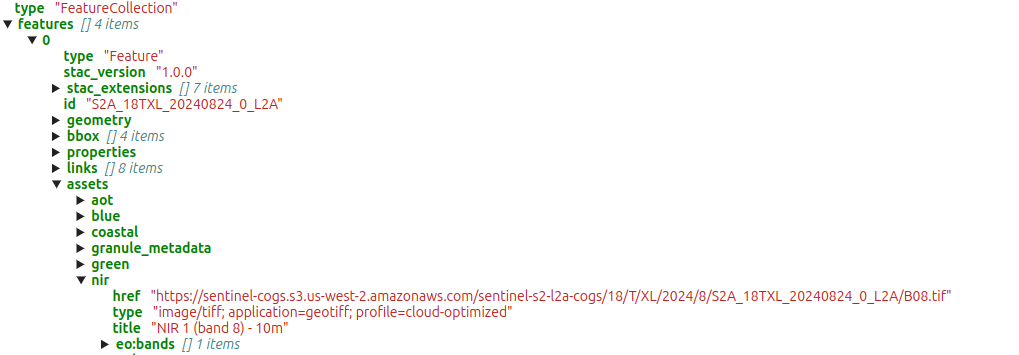

Within each "feature" we find detailed metadata about the data contained.  The spatial extent of the image appears in the "geometry", while date and other information appear under "properties" In the "assets" element, we finally find a list of all the individual data files associated with this feature -- primarily specific "bands" or wavelengths of light that the cameras on board the satellite are able to detect.  While cameras in smart-phones (and most small commericial cube-sats) can only see Red, Green, and Blue, the sensors on board Sentinel-2 can see in quite a lot more wavelengths.  A URL points to the specific TIF file containing the data for each wavelength.  

## STAC to xarray

Rather than work our way though all this metadata manually, we will now draw upon another package that is capable of understanding the information returned by the STAC catalog and helping us access only the parts we need, without downloading entire assets.  Historically this kind of trick was only done with specialized systems and powerful computers such as Google Earth Engine.  Today, open source tools in python make many of the same operations possible with greater flexibility and control. This approach is fundamental to scalable 'cloud-native' analysis of massive satellite data.

Our next step uses a package called `odc.stac` to load just the two spectral bands of interest for us, and access only those parts of each file that correspond to our area of interest.  We will only scratch the surface of `odc.stac` tooling here, but more details can be found in the [odc.stac documentation](https://odc-stac.readthedocs.io/en/latest/intro.html).

In [5]:
import odc.stac

In [6]:

data = odc.stac.load(
    items,
    bands=["nir08", "red"],
    bbox=box,
    resolution=10, # the native resolution is already 10m.  Increase this to ~ 100m for larger cities.
    groupby="solar_day",
    chunks = {} # this tells odc to use dask
    
)

data

<xarray.Dataset> Size: 32MB
Dimensions:      (y: 1627, x: 1220, time: 4)
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
    spatial_ref  int32 4B 32618
  * time         (time) datetime64[ns] 32B 2024-06-15T15:51:53.600000 ... 202...
Data variables:
    nir08        (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>
    red          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>

The default resolution will be the native resolution of the data, 10-meter in the case of this Sentinel-2 data. For large city areas like Los Angeles that need multiple images to tile, consider reducing this resolution, e.g. to 100m, to improve overall performance. Using chunking (`chunks={}`) and grouping (e.g. `groupby="solar_day"`) also help scaling to larger image collections by breaking the processing into smaller steps.  

## Computing NDVI

The most common metric of "greeness" (i.e. vegetation cover) for satellite imagery is the [Normalized Difference Vegetation Index, or NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (see link for details).  Plants are green because they obsorb red light, while reflecting near-infrared.  NDVI compares the difference between these two band intensities to the sum:

$$ NDVI = \frac{NIR - RED}{NIR + RED} $$

This creates a 'normalized' index that should be between -1 (water) and 1 (maximum vegitation).  `xarray` makes it easy to compute operations on different bands (variables), e.g. we can compute the _difference_ between each $(X, Y, Time)$ coordinate in the NIR wavelength to thhat of the red wavelength as `data.nir08 - data.red`.  We can also compute summary statistics across dimensions. Here, becuase we have 4 different timepoints, we will take the median measurement over time -- a common summary statistic that is less sensitive to outliers than the mean.  Lastly, we will drop any "bad" pixels, where the NDVI value is greater than 1.  


In [7]:
ndvi = (
    ((data.nir08 - data.red) / (data.red + data.nir08))
    .median("time", keep_attrs=True)
)

ndvi = ndvi.where(ndvi < 1).compute()

In [8]:
ndvi

<xarray.DataArray (y: 1627, x: 1220)> Size: 16MB
array([[0.88591885, 0.88051675, 0.87161283, ..., 0.85875371, 0.84881165,
        0.86324397],
       [0.85873743, 0.88231669, 0.90861641, ..., 0.75906042, 0.82126435,
        0.84697593],
       [0.84439895, 0.88673668, 0.89681533, ..., 0.77134877, 0.82810371,
        0.84242071],
       ...,
       [0.81399746, 0.45830669, 0.36016143, ...,        nan,        nan,
               nan],
       [0.8458809 , 0.48283024, 0.41006737, ...,        nan,        nan,
               nan],
       [0.82337862, 0.4601535 , 0.44678909, ...,        nan,        nan,
               nan]])
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
    spatial_ref  int32 4B 32618

## Basic visualization 

We can 'peek' at the underlying raster data with the built-in `.plot.imshow()` method, which is built on low-level `matplotlib` tooling. While it is possible to construct reasonably nice static map images with sufficient effort in this way, that approach is neither as user-friendly or as powerful as the more general interactive (javascript-based) maps generated by leafmap, so we won't worry too much about styling.  However, `.plot.imshow()` can be a convenient way to check what an xarray dataset looks like during the analysis process.

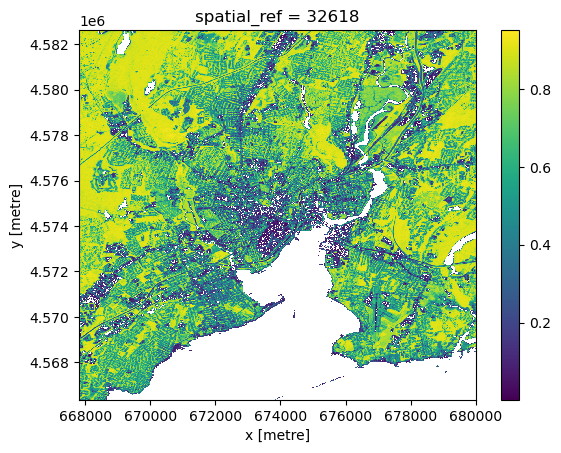

In [9]:
ndvi.plot.imshow()

## File Output

To visualize our dervied data on an interactive map or share it with other researchers, we need to be able to export it to a file.  One of the best choices for this purpose is a format referred to as "Cloud Optimized GeoTiff", or "COG" for short.  A COG file embeds multiple "zooms" and internal tiles, allowing it be rendered rapidly in visualizations.  COG data files still preserve the numerical values of each pixel and associated metadata, making them useful for further computations.  We will take advantage of this latter feature in seeking to summarize the average greeness in each polygon in our redlining data.  The `rioxarray` package provides convenient utilities for input and output (io) between _raster files_ and _xarray_ data structures in python. 

In [11]:
import rioxarray
(ndvi
 .rio.reproject("EPSG:4326")
 .rio.to_raster(raster_path="ndvi.tif", 
                driver="COG")   
)


Side note: optionally, we can also store a copy of our vector data, also setting the projection.  Common formats include geopackage, `.gpkg`, and `.parquet`.  

In [15]:
(city
 .set_crs("EPSG:4326")
 .to_file("new_haven.gpkg") # common open standard
)


# latest option, best performance but less widely known:
city.set_crs("EPSG:4326").to_parquet("new_haven.parquet")
